<div align="center">
    <h5></h5>
    <h1>Mayo Endoscopic Classification With SwinTransformer</h1>
    <h2>Halil İbrahim Dönmezbilek</h2>
</div>


# Data Load & Imports & Seed

In [1]:
from google.colab import drive
drive.mount('/content/drive')

"""
This the Data.zip file tree.
The reason I unzip the data in Google Colab is
  that it is much faster by reducing I/O with the Google API.

data/
    train_and_validation_sets.zip
    test_set.zip
    test_set/
        Mayo 0/
        Mayo 2/
        Mayo 3/
        Mayo 1/
    train_and_validation_sets/
        Mayo 0/
        Mayo 2/
        Mayo 3/
        Mayo 1/
"""

!7z x /content/drive/MyDrive/DI725_Term_Project/Data.zip -o/content

Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/DI725_Term_Project/                                                    1 file, 3848410789 bytes (3671 MiB)

Extracting archive: /content/drive/MyDrive/DI725_Term_Project/Data.zip
 36% 4096 Open              --
Path = /content/drive/MyDrive/DI725_Term_Project/Data.zip
Type = zip
Physical Size = 3848410789

  0%      0% 2 - data/test_set.zip                            1% 2 - data/test_set.zip                            2% 2 - data/test_set.zip

In [2]:
!pip install timm
!pip install ninja
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [20]:
# Standard libraries
import os
import json
import wandb
import random
import subprocess
from pathlib import Path
from collections import Counter

# Third-party libraries
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

# PyTorch
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet101_Weights

from timm import create_model
from timm.data import resolve_model_data_config, create_transform
from timm.models import swin_tiny_patch4_window7_224

# Scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score

# Seeds
seed = 2649614
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# API Key Definitions
from google.colab import userdata
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
os.environ['HF_TOKENB'] = userdata.get('HF_TOKEN')
wandb.login()

True

# Dataset Split

In [4]:
###########################################
#### Preparing The Data For The Models ####
###########################################

# Set the base directory containing the dataset
data_dir = Path('/content/data')


def download_and_extract(url, zip_path, extract_to):
  # Convert Path object to string if necessary
  zip_path = str(zip_path)
  extract_to = str(extract_to)

  # Check if the file already exists
  if os.path.exists(zip_path):
    print(f"{zip_path} already exists. Skipping download.")
  else:
    # Send a request to get the content length
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))

    # Initialize the progress bar
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

    # Download the file with progress bar
    with open(zip_path, 'wb') as f:
      for data in response.iter_content(chunk_size=1024):
        progress_bar.update(len(data))
        f.write(data)
    progress_bar.close()

    # Check if the download was successful before extracting
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
      print("ERROR, something went wrong during download.")
      return  # Stop if download was unsuccessful


    if total_size_in_bytes == progress_bar.n:
      print(f"Extracting {zip_path}")
      subprocess.run(['7z', 'x', zip_path, '-o' + extract_to])
      print(f"Extraction complete for {zip_path}")
    else:
      print("ERROR, something went wrong during download.")

# URLs of the zip files
urls = [
    'https://zenodo.org/records/5827695/files/train_and_validation_sets.zip?download=1',
    'https://zenodo.org/records/5827695/files/test_set.zip?download=1'
]

# Download and extract each file
for url in urls:
  file_name = url.split('/')[-1].split('?')[0]
  zip_path = data_dir / file_name
  extract_folder = data_dir
  download_and_extract(url, zip_path, extract_folder)


train_data = {}
validation_data = {}
image_paths = []
image_labels = []

# Loop through each class directory in the train_and_validation_sets folder
for class_dir in sorted((data_dir / 'train_and_validation_sets').glob('Mayo*')):
  class_name = class_dir.name
  for img_path in class_dir.glob('*.bmp'):
    image_paths.append(Path(img_path))
    image_labels.append(class_name)

# Perform stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, val_idx = next(sss.split(image_paths, image_labels))

train_images = [image_paths[i] for i in train_idx]
train_labels = [image_labels[i] for i in train_idx]
val_images = [image_paths[i] for i in val_idx]
val_labels = [image_labels[i] for i in val_idx]

# Organize the data into dictionaries, ensuring keys are sorted
for class_name in sorted(set(image_labels)):
  train_data[class_name] = [img for img, label in zip(train_images, train_labels) if label == class_name]
  validation_data[class_name] = [img for img, label in zip(val_images, val_labels) if label == class_name]


test_data = {}
# Loop through each class directory in the test_set folder
for class_dir in (data_dir / 'test_set').glob('Mayo*'):
  class_name = class_dir.name
  test_data[class_name] = [Path(img_path) for img_path in class_dir.glob('*.bmp')]


/content/data/train_and_validation_sets.zip already exists. Skipping download.
/content/data/test_set.zip already exists. Skipping download.


# EDA

In [ ]:
# Function to calculate mean and std
def calculate_mean_std(image_paths):
  mean = torch.zeros(3)
  std = torch.zeros(3)
  total_pixels = 0

  for img_path in tqdm(image_paths, desc="Calculating mean and std"):
    img = Image.open(img_path).convert('RGB')
    img = transforms.ToTensor()(img)

    mean += img.mean(dim=(1, 2))
    std += img.std(dim=(1, 2))
    total_pixels += 1

  mean /= total_pixels
  std /= total_pixels

  return mean, std

# Get all training image paths from train_data dictionary
train_image_paths = [img for imgs in train_data.values() for img in imgs]

# Calculate mean and standard deviation
mean, std = calculate_mean_std(train_image_paths)

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculating mean and std: 100%|██████████| 7672/7672 [00:28<00:00, 271.72it/s]

Calculated mean: tensor([0.4144, 0.2877, 0.2182])
Calculated std: tensor([0.2867, 0.2085, 0.1626])


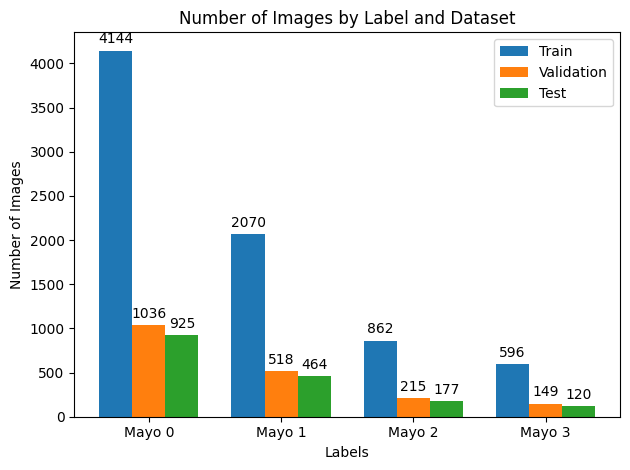

In [ ]:
def prepare_data_summary_counts(train_data, validation_data, test_data):
  label_counts_train = {class_name: len(images) for class_name, images in train_data.items()}
  label_counts_val = {class_name: len(images) for class_name, images in validation_data.items()}
  label_counts_test = {class_name: len(images) for class_name, images in test_data.items()}
  labels = list(train_data.keys())
  train_counts = [label_counts_train.get(label, 0) for label in labels]
  val_counts = [label_counts_val.get(label, 0) for label in labels]
  test_counts = [label_counts_test.get(label, 0) for label in labels]
  return labels, train_counts, val_counts, test_counts


def plot_data_summary(labels, train_counts, val_counts, test_counts):
  x = np.arange(len(labels))  # the label locations
  width = 0.25  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width, train_counts, width, label='Train')
  rects2 = ax.bar(x, val_counts, width, label='Validation')
  rects3 = ax.bar(x + width, test_counts, width, label='Test')

  ax.set_xlabel('Labels')
  ax.set_ylabel('Number of Images')
  ax.set_title('Number of Images by Label and Dataset')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  autolabel(ax, rects1)
  autolabel(ax, rects2)
  autolabel(ax, rects3)

  fig.tight_layout()
  plt.show()

def autolabel(ax, rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

labels, train_counts, val_counts, test_counts = prepare_data_summary_counts(train_data, validation_data, test_data)
plot_data_summary(labels, train_counts, val_counts, test_counts)


# Baseline Models

## Utils for Baseline Models

In [5]:
def evaluate_predictions(y_true, y_pred, split_name):
  conf_matrix = confusion_matrix(y_true, y_pred)
  qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
  accuracy = accuracy_score(y_true, y_pred)
  print(f"{split_name} Quadratic Weighted Kappa: {qwk:.4f}")
  print(f"{split_name} Accuracy: {accuracy:.4f}")
  return conf_matrix

def plot_confusion_matrix(conf_matrix, class_labels, table_title):
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
  plt.colorbar()
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation=45)
  plt.yticks(tick_marks, class_labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'{table_title} Confusion Matrix')
  thresh = conf_matrix.max() / 2.
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
  plt.tight_layout()
  plt.show()

list_of_labels = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']

## Naive Model

Naive Model Validation Quadratic Weighted Kappa: 0.0000
Naive Model Validation Accuracy: 0.5401


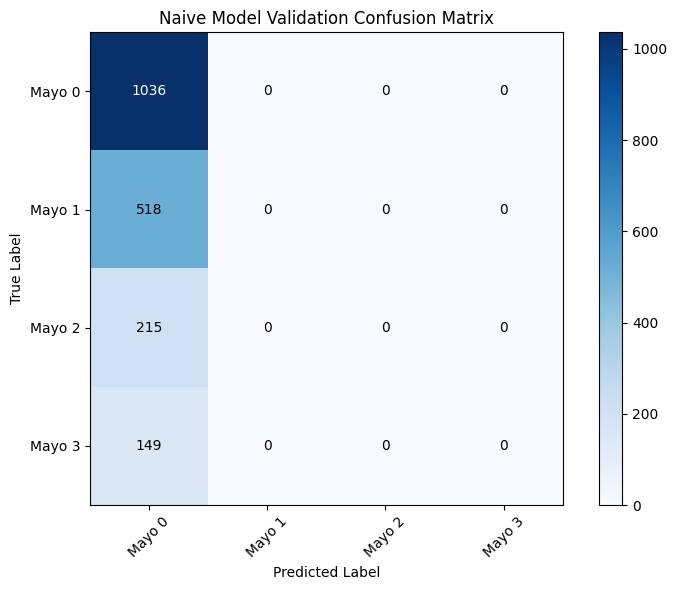

Naive Model Test Quadratic Weighted Kappa: 0.0000
Naive Model Test Accuracy: 0.5486


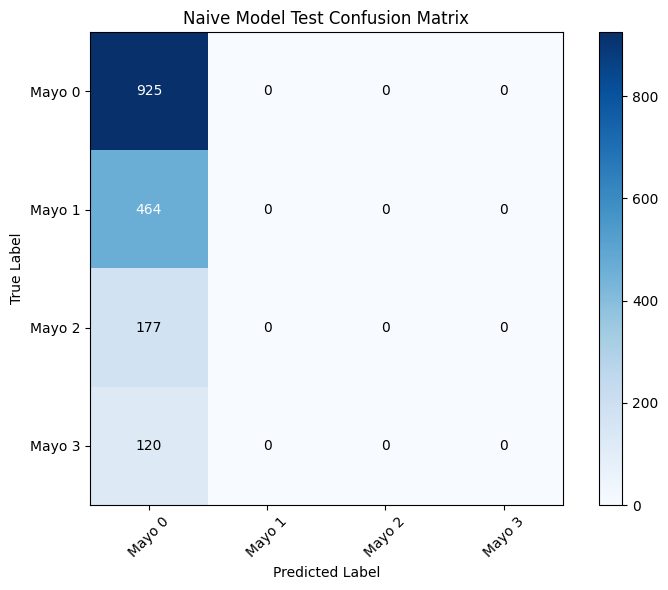

In [6]:
class MostFrequent:
  def fit(self, y_train):
    self.most_frequent_class = max(set(y_train), key=y_train.count)

  def predict(self, X):
    return [self.most_frequent_class for _ in range(len(X))]

def combine_data(data_dict):
  X, y = [], []
  for class_name, img_paths in data_dict.items():
    X.extend(img_paths)
    y.extend([int(class_name[-1])] * len(img_paths))
  return X, y


# Initialize the model
baseline_model = MostFrequent()

# Combine and fit training data
X_train, y_train = combine_data(train_data)
baseline_model.fit(y_train)

# Evaluate validation set
X_val, y_val = combine_data(validation_data)
y_pred_val = baseline_model.predict(X_val)
val_conf_matrix = evaluate_predictions(y_val, y_pred_val, "Naive Model Validation")
plot_confusion_matrix(val_conf_matrix, list_of_labels, "Naive Model Validation")

# Evaluate test set
X_test, y_test = combine_data(test_data)
y_pred = baseline_model.predict(X_test)
test_conf_matrix = evaluate_predictions(y_test, y_pred, "Naive Model Test")
plot_confusion_matrix(test_conf_matrix, list_of_labels, "Naive Model Test")

## Non-Transformer Deep Learning Model

In [14]:
# Define transformations
# Calculated mean: tensor([0.4144, 0.2877, 0.2182])
# Calculated std: tensor([0.2867, 0.2085, 0.1626])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4144, 0.2877, 0.2182], std=[0.2867, 0.2085, 0.1626])
])

class BMPDataset(ImageFolder):
  def __init__(self, root, file_paths, transform=None):
    super().__init__(root, transform=transform)
    self.samples = [(path, int(path.parent.name.split()[-1])) for path in file_paths if path.suffix == '.bmp']
    self.imgs = self.samples
    self.classes = list(range(len(self.class_to_idx)))


def gather_paths(data_dict):
  return [path for paths in data_dict.values() for path in paths]

# Model Initialization
def non_transformer_initialize_model():
  weights = ResNet101_Weights.IMAGENET1K_V1
  resnet101 = models.resnet101(weights=weights)
  resnet101 = resnet101.to(device)

  # Unfreeze the pre-trained weights
  for param in resnet101.parameters():
      param.requires_grad = True

  # Replaced the last fully connected layer with a new one tailored for the number of classes in your dataset
  num_classes = 4  # Specify the number of classes (e.g., Mayo 0, Mayo 1, Mayo 2, Mayo 3)
  resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes).to(device)

  return resnet101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.5MB/s]


Non-Transformer Deep Learning Model Validation Quadratic Weighted Kappa: 0.7024
Non-Transformer Deep Learning Model Validation Accuracy: 0.6971
Epoch 1 Loss: 0.8643, Validation QWK: 0.7024
Saved Best Model with QWK: 0.7024
Non-Transformer Deep Learning Model Validation Quadratic Weighted Kappa: 0.7545
Non-Transformer Deep Learning Model Validation Accuracy: 0.7112
Epoch 2 Loss: 0.7350, Validation QWK: 0.7545
Saved Best Model with QWK: 0.7545
Non-Transformer Deep Learning Model Validation Quadratic Weighted Kappa: 0.6621
Non-Transformer Deep Learning Model Validation Accuracy: 0.7033
Epoch 3 Loss: 0.7044, Validation QWK: 0.6621
Non-Transformer Deep Learning Model Validation Quadratic Weighted Kappa: 0.7469
Non-Transformer Deep Learning Model Validation Accuracy: 0.7185
Epoch 4 Loss: 0.7015, Validation QWK: 0.7469
Non-Transformer Deep Learning Model Validation Quadratic Weighted Kappa: 0.7319
Non-Transformer Deep Learning Model Validation Accuracy: 0.6877
Epoch 5 Loss: 0.6780, Validation

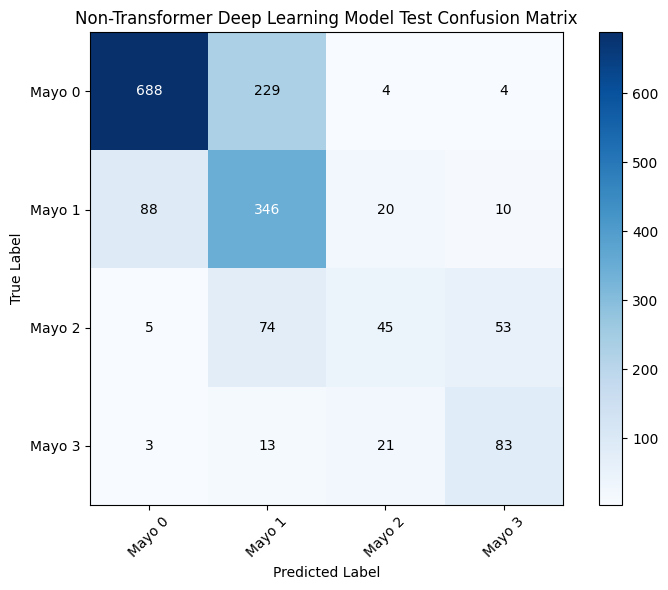

In [6]:
train_paths = gather_paths(train_data)
train_dataset = BMPDataset(root=data_dir / 'train_and_validation_sets', file_paths=train_paths, transform=transform)

validation_paths = gather_paths(validation_data)
validation_dataset = BMPDataset(root=data_dir / 'train_and_validation_sets', file_paths=validation_paths, transform=transform)

test_paths = gather_paths(test_data)
test_dataset = BMPDataset(root=data_dir / 'test_set', file_paths=test_paths, transform=transform)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def validate_model(model, loader, criterion, device):
  model.eval()
  validation_loss = 0.0
  all_preds, all_labels = [], []
  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      validation_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  conf_matrix = evaluate_predictions(all_labels, all_preds, "Non-Transformer Deep Learning Model Validation")

  qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
  accuracy = accuracy_score(all_labels, all_preds)
  return validation_loss / len(loader), qwk

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
  best_qwk = -1.0
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    val_loss, val_qwk = validate_model(model, val_loader, criterion, device)
    print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_loader):.4f}, Validation QWK: {val_qwk:.4f}')

    # Save the model if the QWK improves
    if val_qwk > best_qwk:
      best_qwk = val_qwk
      torch.save(model.state_dict(), save_path)
      print(f'Saved Best Model with QWK: {best_qwk:.4f}')

def evaluate_test_model(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  conf_matrix = evaluate_predictions(all_labels, all_preds, "Non-Transformer Deep Learning Model Test")
  plot_confusion_matrix(conf_matrix, list_of_labels, "Non-Transformer Deep Learning Model Test")


model = non_transformer_initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

non_transformer_best_model_path = "/content/drive/MyDrive/DI725_Term_Project/non_transformer_best_model_path.pth"

train_validate_model(model, train_dataloader, validation_dataloader, criterion, optimizer, 30, device, non_transformer_best_model_path)

model.load_state_dict(torch.load(non_transformer_best_model_path))
evaluate_test_model(model, test_dataloader, device)


# Proposed Transformer Model

In [7]:
def extract_color_features(image, num_bins=16):

  image = np.array(image)

  hist_r = np.histogram(image[:, :, 0], bins=num_bins, range=(0, 256))[0]
  hist_g = np.histogram(image[:, :, 1], bins=num_bins, range=(0, 256))[0]
  hist_b = np.histogram(image[:, :, 2], bins=num_bins, range=(0, 256))[0]

  hist_r = hist_r / np.sum(hist_r)
  hist_g = hist_g / np.sum(hist_g)
  hist_b = hist_b / np.sum(hist_b)

  hist = np.concatenate((hist_r, hist_g, hist_b))
  return hist

class SwinDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None, num_bins=16):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform
    self.num_bins = num_bins

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    label = self.labels[idx]
    if self.transform:
        transformed_image = self.transform(image)
    color_features = extract_color_features(image, self.num_bins)
    color_features = torch.tensor(color_features, dtype=torch.float32)
    return transformed_image, color_features, label

class SwinColorFusionNet(nn.Module):
  def __init__(self, num_classes=4, pretrained=True, num_bins=16):
    super(SwinColorFusionNet, self).__init__()
    self.swin_transformer = swin_tiny_patch4_window7_224(pretrained=pretrained)
    self.color_feature_dim = num_bins * 3  # Since I use histograms with num_bins for each of R, G, and B

    # Fully connected layer for the combined features
    self.fc1 = nn.Linear(768 + self.color_feature_dim, 128)  # 768 from Swin Transformer + color features
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x, color_features):
    # Swin Transformer features
    swin_features = self.swin_transformer.forward_features(x)
    swin_features = swin_features.mean(dim=[1, 2])  # Global average pooling

    # Concatenate Swin Transformer features with color features
    combined_features = torch.cat((swin_features, color_features), dim=1)

    # Pass through the MLP
    x = self.fc1(combined_features)
    x = self.relu(x)
    output = self.fc2(x)
    return output

In [7]:
swin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4144, 0.2877, 0.2182], std=[0.2867, 0.2085, 0.1626])
])
train_labels = [int(str(x)[-1]) for x in train_labels]
val_labels = [int(str(x)[-1]) for x in val_labels]

test_paths = []
test_labels = []
for class_name, paths in test_data.items():
  label = int(class_name.split(' ')[-1])
  test_paths.extend(paths)
  test_labels.extend([label] * len(paths))

train_dataset = SwinDataset(train_images, train_labels, transform=swin_transform, num_bins=32)
val_dataset = SwinDataset(val_images, val_labels, transform=swin_transform, num_bins=32)
test_dataset = SwinDataset(test_paths, test_labels, transform=swin_transform, num_bins=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

def train_model(config=None):
  with wandb.init(config=config):
    config = wandb.config

    model = SwinColorFusionNet(num_classes=4, pretrained=True, num_bins=32).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    best_val_qwk = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(config.epochs):
      model.train()
      running_loss = 0.0
      for data in train_loader:
        inputs, color_features, labels = data
        inputs, color_features, labels = inputs.to(device), color_features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, color_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(train_loader.dataset)

      model.eval()
      val_running_loss = 0.0
      val_running_corrects = 0
      all_preds = []
      all_labels = []
      for data in val_loader:
        inputs, color_features, labels = data
        if isinstance(labels, tuple):
            labels = labels[0]  # Unpack the tuple
        inputs, color_features, labels = inputs.to(device), color_features.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs, color_features)
            loss = criterion(outputs, labels)
        val_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_running_corrects += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      val_loss = val_running_loss / len(val_loader.dataset)
      val_acc = val_running_corrects.double() / len(val_loader.dataset)
      val_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

      print(f'Epoch {epoch+1}/{config.epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val QWK: {val_qwk:.4f}')

      wandb.log({
              "epoch": epoch,
              "train_loss": epoch_loss,
              "val_loss": val_loss,
              "val_acc": val_acc,
              "val_qwk": val_qwk
          })

      if val_qwk > best_val_qwk:
          best_val_qwk = val_qwk
          best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)


    filename = f"best_model_{wandb.run.id}.pth"
    filepath = os.path.join("/content/drive/MyDrive/DI725_Term_Project/", filename)
    torch.save(model.state_dict(), filepath)

    print('Best model saved with QWK: {:.4f}'.format(best_val_qwk))



    test_accuracy, test_qwk, test_labels, test_preds = evaluate_model(model, test_loader)
    conf_matrix = evaluate_predictions(test_labels, test_preds, "Test")

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(len(list_of_labels))
    plt.xticks(tick_marks, list_of_labels, rotation=45)
    plt.yticks(tick_marks, list_of_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'SwinColorFusionNet Test Confusion Matrix')
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    plt.tight_layout()

    wandb.log({
        "test_accuracy": test_accuracy,
        "test_qwk": test_qwk,
        "confusion_matrix": wandb.Image(plt)
        })

def evaluate_model(model, dataloader):
  model.eval()
  running_corrects = 0
  all_preds = []
  all_labels = []
  for data in dataloader:
    inputs, color_features, labels = data
    inputs, color_features, labels = inputs.to(device), color_features.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs, color_features)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

  accuracy = running_corrects.double() / len(dataloader.dataset)
  qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

  return accuracy, qwk, all_labels, all_preds


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Create sweep with ID: 48nenzve
Sweep URL: https://wandb.ai/halil-donmezbilek/DI725_Term_Project/sweeps/48nenzve


wandb: Agent Starting Run: 1d7ugpx3 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	lr: 0.0001


Epoch 1/30, Loss: 0.6367, Val Loss: 0.4754, Val Acc: 0.7873, Val QWK: 0.8747
Epoch 2/30, Loss: 0.4674, Val Loss: 0.4625, Val Acc: 0.7899, Val QWK: 0.8622
Epoch 3/30, Loss: 0.3771, Val Loss: 0.4755, Val Acc: 0.7961, Val QWK: 0.8803
Epoch 4/30, Loss: 0.2834, Val Loss: 0.5736, Val Acc: 0.7857, Val QWK: 0.8740
Epoch 5/30, Loss: 0.2079, Val Loss: 0.5951, Val Acc: 0.7982, Val QWK: 0.8717
Epoch 6/30, Loss: 0.1502, Val Loss: 0.6936, Val Acc: 0.7847, Val QWK: 0.8524
Epoch 7/30, Loss: 0.1189, Val Loss: 0.7068, Val Acc: 0.7883, Val QWK: 0.8688
Epoch 8/30, Loss: 0.0991, Val Loss: 0.7597, Val Acc: 0.7654, Val QWK: 0.8568
Epoch 9/30, Loss: 0.0858, Val Loss: 0.7748, Val Acc: 0.7935, Val QWK: 0.8624
Epoch 10/30, Loss: 0.0690, Val Loss: 0.7389, Val Acc: 0.7862, Val QWK: 0.8686
Epoch 11/30, Loss: 0.0823, Val Loss: 0.8577, Val Acc: 0.7935, Val QWK: 0.8639
Epoch 12/30, Loss: 0.0732, Val Loss: 0.8696, Val Acc: 0.7805, Val QWK: 0.8626
Epoch 13/30, Loss: 0.0545, Val Loss: 0.8221, Val Acc: 0.7847, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▆▆▇▅█▅▆▁▇▅▇▄▅▄█▆█▂▇▁▇▇▇▇█▆▆▇█▆
val_loss,▁▁▁▂▂▃▄▄▄▄▅▅▅▆▆▇▆▇▆▆▅▇▆▅▅▆▆▇█▇
val_qwk,▇▅█▇▇▄▆▅▅▆▆▅▆▆▆▅▅▁▇▃▇▆▇▆▇▄▇▆▇▇
epoch,29
test_accuracy,0.77461
test_qwk,0.85091
train_loss,0.04177


wandb: Agent Starting Run: zocojjjc with config:
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	lr: 1e-05


Epoch 1/30, Loss: 0.7822, Val Loss: 0.5234, Val Acc: 0.7690, Val QWK: 0.8578
Epoch 2/30, Loss: 0.5171, Val Loss: 0.4720, Val Acc: 0.7857, Val QWK: 0.8737
Epoch 3/30, Loss: 0.4627, Val Loss: 0.4641, Val Acc: 0.7784, Val QWK: 0.8673
Epoch 4/30, Loss: 0.4242, Val Loss: 0.4461, Val Acc: 0.7982, Val QWK: 0.8825
Epoch 5/30, Loss: 0.3902, Val Loss: 0.4515, Val Acc: 0.8087, Val QWK: 0.8826
Epoch 6/30, Loss: 0.3556, Val Loss: 0.4572, Val Acc: 0.8008, Val QWK: 0.8820
Epoch 7/30, Loss: 0.3125, Val Loss: 0.4912, Val Acc: 0.8092, Val QWK: 0.8894
Epoch 8/30, Loss: 0.2718, Val Loss: 0.4989, Val Acc: 0.8055, Val QWK: 0.8887
Epoch 9/30, Loss: 0.2302, Val Loss: 0.5285, Val Acc: 0.8040, Val QWK: 0.8847
Epoch 10/30, Loss: 0.1900, Val Loss: 0.5837, Val Acc: 0.7982, Val QWK: 0.8796
Epoch 11/30, Loss: 0.1535, Val Loss: 0.6544, Val Acc: 0.7899, Val QWK: 0.8711
Epoch 12/30, Loss: 0.1171, Val Loss: 0.7097, Val Acc: 0.7972, Val QWK: 0.8725
Epoch 13/30, Loss: 0.0899, Val Loss: 0.7535, Val Acc: 0.8040, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▃▆█▆█▇▇▆▅▆▇▄▅▇▆▇▇▆▇▆▅▆▅█▇▇▆▆
val_loss,▂▁▁▁▁▁▁▂▂▂▃▄▄▅▄▅▆▅▅▆▆▆█▆▇▆▆▇█▇
val_qwk,▁▅▃▆▇▆██▇▆▄▄▇▁▅▇▄▅▆▅▅▆▅▅▄▇▇▇▅▅
epoch,29
test_accuracy,0.78648
test_qwk,0.86452
train_loss,0.0261


wandb: Agent Starting Run: 4urvs8tc with config:
wandb: 	batch_size: 16
wandb: 	epochs: 60
wandb: 	lr: 0.0001


Epoch 1/60, Loss: 0.6350, Val Loss: 0.5267, Val Acc: 0.7643, Val QWK: 0.8550
Epoch 2/60, Loss: 0.4728, Val Loss: 0.4856, Val Acc: 0.7951, Val QWK: 0.8815
Epoch 3/60, Loss: 0.3859, Val Loss: 0.5236, Val Acc: 0.7800, Val QWK: 0.8453
Epoch 4/60, Loss: 0.2925, Val Loss: 0.5703, Val Acc: 0.7862, Val QWK: 0.8718
Epoch 5/60, Loss: 0.2048, Val Loss: 0.6113, Val Acc: 0.7883, Val QWK: 0.8680
Epoch 6/60, Loss: 0.1520, Val Loss: 0.8986, Val Acc: 0.7753, Val QWK: 0.8355
Epoch 7/60, Loss: 0.1233, Val Loss: 0.8058, Val Acc: 0.7894, Val QWK: 0.8578
Epoch 8/60, Loss: 0.1001, Val Loss: 0.7639, Val Acc: 0.7977, Val QWK: 0.8766
Epoch 9/60, Loss: 0.0767, Val Loss: 0.9014, Val Acc: 0.7873, Val QWK: 0.8542
Epoch 10/60, Loss: 0.0897, Val Loss: 0.7595, Val Acc: 0.7993, Val QWK: 0.8668
Epoch 11/60, Loss: 0.0856, Val Loss: 0.6970, Val Acc: 0.7826, Val QWK: 0.8696
Epoch 12/60, Loss: 0.0694, Val Loss: 0.8540, Val Acc: 0.7956, Val QWK: 0.8700
Epoch 13/60, Loss: 0.0492, Val Loss: 0.9481, Val Acc: 0.7920, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▇▆▆▇██▆▇▄▆▅▆▇▁▂▇▆▃▆▆▇▇▅▇▃█▇▅▅▅▃▇▆▄▅▇▄▄▂
val_loss,▁▁▂▂▄▃▃▃▅▅▆▅▅▅▅▅▅▆▅▅▆▆▆▅▅▇▆█▆▅▇█▆▇▅▆▅▅▅▇
val_qwk,▅█▇▆▅▇▆▇▆▅▆▆▆▆▁▃▇▆▃▆▅▅▇▅▆▁▇▇▅▄▄▂▇▆▅▆▅▆▄▃
epoch,59
test_accuracy,0.72539
test_qwk,0.81433
train_loss,0.02525


wandb: Agent Starting Run: yn6vvz8v with config:
wandb: 	batch_size: 16
wandb: 	epochs: 60
wandb: 	lr: 1e-05


Epoch 1/60, Loss: 0.7542, Val Loss: 0.5005, Val Acc: 0.7732, Val QWK: 0.8669
Epoch 2/60, Loss: 0.5003, Val Loss: 0.4580, Val Acc: 0.8034, Val QWK: 0.8782
Epoch 3/60, Loss: 0.4464, Val Loss: 0.4547, Val Acc: 0.8014, Val QWK: 0.8837
Epoch 4/60, Loss: 0.4004, Val Loss: 0.4585, Val Acc: 0.8076, Val QWK: 0.8835
Epoch 5/60, Loss: 0.3676, Val Loss: 0.4857, Val Acc: 0.7894, Val QWK: 0.8750
Epoch 6/60, Loss: 0.3295, Val Loss: 0.4935, Val Acc: 0.7956, Val QWK: 0.8701
Epoch 7/60, Loss: 0.2961, Val Loss: 0.4846, Val Acc: 0.8003, Val QWK: 0.8853
Epoch 8/60, Loss: 0.2383, Val Loss: 0.5125, Val Acc: 0.8014, Val QWK: 0.8726
Epoch 9/60, Loss: 0.2038, Val Loss: 0.5668, Val Acc: 0.8003, Val QWK: 0.8799
Epoch 10/60, Loss: 0.1640, Val Loss: 0.6146, Val Acc: 0.8040, Val QWK: 0.8802
Epoch 11/60, Loss: 0.1347, Val Loss: 0.6415, Val Acc: 0.8050, Val QWK: 0.8822
Epoch 12/60, Loss: 0.1014, Val Loss: 0.7257, Val Acc: 0.7961, Val QWK: 0.8716
Epoch 13/60, Loss: 0.0945, Val Loss: 0.7453, Val Acc: 0.7935, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▄▅▅▆▆▄▅▆▄▅▄▇▇▄▇█▆▅▅▅▆▄▆▄▆▇▇▆▄▅▆█▆▆▅▆▄
val_loss,▁▁▁▁▁▁▂▂▃▄▄▄▄▅▄▄▅▄▅▅▆▆▆▆▆▅▇▆▅▆▆▇▇▆▆▆▇▇▇█
val_qwk,▂▅▇▄▇▄▆▇▄▅▆▂▄▃▆▇▄██▇▄▅▄▅▅▆▁▅▆▇▄▁▄▅█▆▅▆▆▂
epoch,59
test_accuracy,0.76216
test_qwk,0.83686
train_loss,0.01457


wandb: Agent Starting Run: lzb6t6ve with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	lr: 0.0001


Epoch 1/30, Loss: 0.6417, Val Loss: 0.4827, Val Acc: 0.7789, Val QWK: 0.8561
Epoch 2/30, Loss: 0.4858, Val Loss: 0.4887, Val Acc: 0.7862, Val QWK: 0.8582
Epoch 3/30, Loss: 0.3866, Val Loss: 0.4585, Val Acc: 0.8008, Val QWK: 0.8810
Epoch 4/30, Loss: 0.2797, Val Loss: 0.6290, Val Acc: 0.7357, Val QWK: 0.8503
Epoch 5/30, Loss: 0.2157, Val Loss: 0.6037, Val Acc: 0.7977, Val QWK: 0.8818
Epoch 6/30, Loss: 0.1561, Val Loss: 0.7975, Val Acc: 0.7659, Val QWK: 0.8258
Epoch 7/30, Loss: 0.1137, Val Loss: 0.7282, Val Acc: 0.7722, Val QWK: 0.8582
Epoch 8/30, Loss: 0.0909, Val Loss: 0.8362, Val Acc: 0.7628, Val QWK: 0.8512
Epoch 9/30, Loss: 0.0830, Val Loss: 0.9614, Val Acc: 0.7696, Val QWK: 0.8549
Epoch 10/30, Loss: 0.0842, Val Loss: 0.7910, Val Acc: 0.7899, Val QWK: 0.8745
Epoch 11/30, Loss: 0.0561, Val Loss: 0.9070, Val Acc: 0.7753, Val QWK: 0.8523
Epoch 12/30, Loss: 0.0777, Val Loss: 0.8842, Val Acc: 0.7826, Val QWK: 0.8569
Epoch 13/30, Loss: 0.0644, Val Loss: 0.8204, Val Acc: 0.7888, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▆▆█▁█▄▅▄▅▇▅▆▇▅▆▇▇▆▅▅▇▅▄▇▄▅▇▆▆▅
val_loss,▁▁▁▃▂▄▄▅▆▄▆▅▅▅▆▇▇▆▆█▅▇▇▇▇█▇▇▅█
val_qwk,▅▅█▄█▁▅▄▅▇▄▅▇▆▅▅▇▆▆▅▆▅▅▇▄▅▆▄▆▄
epoch,29
test_accuracy,0.74437
test_qwk,0.82097
train_loss,0.02655


wandb: Agent Starting Run: b0lw861z with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	lr: 1e-05


Epoch 1/30, Loss: 0.7356, Val Loss: 0.5063, Val Acc: 0.7894, Val QWK: 0.8594
Epoch 2/30, Loss: 0.5020, Val Loss: 0.4655, Val Acc: 0.7967, Val QWK: 0.8762
Epoch 3/30, Loss: 0.4555, Val Loss: 0.4455, Val Acc: 0.7946, Val QWK: 0.8833
Epoch 4/30, Loss: 0.4167, Val Loss: 0.4490, Val Acc: 0.8029, Val QWK: 0.8844
Epoch 5/30, Loss: 0.3860, Val Loss: 0.4435, Val Acc: 0.7987, Val QWK: 0.8818
Epoch 6/30, Loss: 0.3410, Val Loss: 0.4748, Val Acc: 0.8040, Val QWK: 0.8871
Epoch 7/30, Loss: 0.3159, Val Loss: 0.4570, Val Acc: 0.8139, Val QWK: 0.8886
Epoch 8/30, Loss: 0.2630, Val Loss: 0.5288, Val Acc: 0.7972, Val QWK: 0.8699
Epoch 9/30, Loss: 0.2244, Val Loss: 0.5270, Val Acc: 0.8076, Val QWK: 0.8858
Epoch 10/30, Loss: 0.1803, Val Loss: 0.5722, Val Acc: 0.7998, Val QWK: 0.8774
Epoch 11/30, Loss: 0.1481, Val Loss: 0.6181, Val Acc: 0.7998, Val QWK: 0.8781
Epoch 12/30, Loss: 0.1201, Val Loss: 0.7073, Val Acc: 0.8045, Val QWK: 0.8811
Epoch 13/30, Loss: 0.1008, Val Loss: 0.7323, Val Acc: 0.8003, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▃▃▅▄▅█▄▆▄▄▆▄▁▅▃▅▄▅▄▅▂▄▃▃▆▃▃▆▂
val_loss,▂▁▁▁▁▁▁▂▂▂▃▄▄▆▅▆▆▆▆▆▇▆▇█▇▇▇█▇█
val_qwk,▁▅▇▇▆██▄▇▅▅▆▆▂▆▄▇▇▆▅▆▄▆▄▅▇▄▆▇▆
epoch,29
test_accuracy,0.75919
test_qwk,0.85238
train_loss,0.03206


wandb: Agent Starting Run: fu1bowp8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 60
wandb: 	lr: 0.0001


Epoch 1/60, Loss: 0.6481, Val Loss: 0.4862, Val Acc: 0.7789, Val QWK: 0.8795
Epoch 2/60, Loss: 0.4726, Val Loss: 0.4685, Val Acc: 0.7961, Val QWK: 0.8790
Epoch 3/60, Loss: 0.3736, Val Loss: 0.5010, Val Acc: 0.7987, Val QWK: 0.8760
Epoch 4/60, Loss: 0.2827, Val Loss: 0.5799, Val Acc: 0.7810, Val QWK: 0.8577
Epoch 5/60, Loss: 0.2166, Val Loss: 0.5105, Val Acc: 0.7998, Val QWK: 0.8774
Epoch 6/60, Loss: 0.1609, Val Loss: 0.6599, Val Acc: 0.7920, Val QWK: 0.8662
Epoch 7/60, Loss: 0.1065, Val Loss: 0.7409, Val Acc: 0.7883, Val QWK: 0.8666
Epoch 8/60, Loss: 0.0996, Val Loss: 0.7661, Val Acc: 0.7935, Val QWK: 0.8776
Epoch 9/60, Loss: 0.0784, Val Loss: 0.9167, Val Acc: 0.7758, Val QWK: 0.8693
Epoch 10/60, Loss: 0.0812, Val Loss: 0.8242, Val Acc: 0.8040, Val QWK: 0.8813
Epoch 11/60, Loss: 0.0669, Val Loss: 0.8392, Val Acc: 0.7914, Val QWK: 0.8646
Epoch 12/60, Loss: 0.0597, Val Loss: 0.7870, Val Acc: 0.8029, Val QWK: 0.8826
Epoch 13/60, Loss: 0.0604, Val Loss: 0.8934, Val Acc: 0.7873, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▆▃▇▅▆█▅▄▆▃▄▂▇▂▂▂▃▅▂▃▃▃▆▅▅▇▇▁█▅▁▃▄▄▄▇▄▃▅
val_loss,▁▁▂▁▃▃▄▄▄▄▄▄▄▅▅▅▆▆▅▅▆▆▅▅▇▆▅█▄▆▅▇▆█▆▅▆▆▆▆
val_qwk,██▄▇▅▇█▅▅▅▅▃▁▇▄▄▂▂▆▅▄▅▄▇▅▆▇▇▅▆▆▅▄▆▅▅▇▆▄▆
epoch,59
test_accuracy,0.75326
test_qwk,0.83867
train_loss,0.02034


wandb: Agent Starting Run: hugdcs6d with config:
wandb: 	batch_size: 32
wandb: 	epochs: 60
wandb: 	lr: 1e-05


Epoch 1/60, Loss: 0.7551, Val Loss: 0.5058, Val Acc: 0.7826, Val QWK: 0.8569
Epoch 2/60, Loss: 0.5075, Val Loss: 0.4925, Val Acc: 0.7763, Val QWK: 0.8688
Epoch 3/60, Loss: 0.4571, Val Loss: 0.4654, Val Acc: 0.7993, Val QWK: 0.8708
Epoch 4/60, Loss: 0.4199, Val Loss: 0.5298, Val Acc: 0.7742, Val QWK: 0.8491
Epoch 5/60, Loss: 0.3823, Val Loss: 0.4638, Val Acc: 0.8060, Val QWK: 0.8819
Epoch 6/60, Loss: 0.3421, Val Loss: 0.4584, Val Acc: 0.8087, Val QWK: 0.8824
Epoch 7/60, Loss: 0.3043, Val Loss: 0.4873, Val Acc: 0.8008, Val QWK: 0.8749
Epoch 8/60, Loss: 0.2577, Val Loss: 0.4995, Val Acc: 0.8076, Val QWK: 0.8831
Epoch 9/60, Loss: 0.2132, Val Loss: 0.5589, Val Acc: 0.8024, Val QWK: 0.8805
Epoch 10/60, Loss: 0.1710, Val Loss: 0.6041, Val Acc: 0.8060, Val QWK: 0.8836
Epoch 11/60, Loss: 0.1425, Val Loss: 0.6485, Val Acc: 0.7977, Val QWK: 0.8700
Epoch 12/60, Loss: 0.1125, Val Loss: 0.7408, Val Acc: 0.7967, Val QWK: 0.8815
Epoch 13/60, Loss: 0.0899, Val Loss: 0.7616, Val Acc: 0.7925, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▁█▆██▆▅▅▅▆▄▅▃▄▆▄▄▅▆▅▅▇▅▇▇▂▅▆▅▆▇▇▄▇▇█▅▆
val_loss,▁▁▂▁▁▁▂▂▃▄▄▄▅▅▅▅▅▆▅▆▇▆▆▇▆▆▆▇▆▆▆▆▇▇▇▇▆▆▇█
val_qwk,▃▅▁█▆██▅▇▆▇▆▅▅▅▄▆▆▅▄▆▅▇▇▃▇▇▅▆▇▇▇▆▇▃▇▇▇▇▅
epoch,59
test_accuracy,0.76394
test_qwk,0.84206
train_loss,0.01461


wandb: Agent Starting Run: imdzywlz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	lr: 0.0001


Epoch 1/30, Loss: 0.6365, Val Loss: 0.5320, Val Acc: 0.7513, Val QWK: 0.8371
Epoch 2/30, Loss: 0.4702, Val Loss: 0.4597, Val Acc: 0.7967, Val QWK: 0.8762
Epoch 3/30, Loss: 0.3815, Val Loss: 0.5091, Val Acc: 0.7914, Val QWK: 0.8600
Epoch 4/30, Loss: 0.2896, Val Loss: 0.6336, Val Acc: 0.7539, Val QWK: 0.8579
Epoch 5/30, Loss: 0.2112, Val Loss: 0.6572, Val Acc: 0.7888, Val QWK: 0.8577
Epoch 6/30, Loss: 0.1611, Val Loss: 0.6907, Val Acc: 0.7941, Val QWK: 0.8751
Epoch 7/30, Loss: 0.1322, Val Loss: 0.7927, Val Acc: 0.7774, Val QWK: 0.8404
Epoch 8/30, Loss: 0.1120, Val Loss: 0.7176, Val Acc: 0.7868, Val QWK: 0.8732
Epoch 9/30, Loss: 0.0801, Val Loss: 0.7390, Val Acc: 0.7909, Val QWK: 0.8769
Epoch 10/30, Loss: 0.0725, Val Loss: 0.8432, Val Acc: 0.7664, Val QWK: 0.8657
Epoch 11/30, Loss: 0.0705, Val Loss: 0.8092, Val Acc: 0.7836, Val QWK: 0.8691
Epoch 12/30, Loss: 0.0608, Val Loss: 0.9014, Val Acc: 0.7810, Val QWK: 0.8656
Epoch 13/30, Loss: 0.0760, Val Loss: 0.9202, Val Acc: 0.7727, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▁▅▆▄▅▆▃▅▅▄▆▅▅▄▆▅▄▅▆█▇▅▄▆▆▅▃
val_loss,▂▁▂▃▃▃▅▄▄▅▅▆▆▅▇▇▆▅▆▇▆▅▅▅▇▆▇▇██
val_qwk,▂▇▅▅▅▇▂▇█▆▆▆▅▆▄▅▆▇▅▄▅▇█▇▅▅▆▇▅▁
epoch,29
test_accuracy,0.75267
test_qwk,0.82646
train_loss,0.03029


wandb: Agent Starting Run: fqiwy340 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	lr: 1e-05


Epoch 1/30, Loss: 0.8132, Val Loss: 0.5470, Val Acc: 0.7596, Val QWK: 0.8621
Epoch 2/30, Loss: 0.5105, Val Loss: 0.4614, Val Acc: 0.7914, Val QWK: 0.8750
Epoch 3/30, Loss: 0.4585, Val Loss: 0.5032, Val Acc: 0.7852, Val QWK: 0.8633
Epoch 4/30, Loss: 0.4138, Val Loss: 0.4489, Val Acc: 0.8060, Val QWK: 0.8831
Epoch 5/30, Loss: 0.3821, Val Loss: 0.4352, Val Acc: 0.8128, Val QWK: 0.8875
Epoch 6/30, Loss: 0.3493, Val Loss: 0.5255, Val Acc: 0.7748, Val QWK: 0.8651
Epoch 7/30, Loss: 0.2978, Val Loss: 0.5049, Val Acc: 0.8060, Val QWK: 0.8783
Epoch 8/30, Loss: 0.2612, Val Loss: 0.5288, Val Acc: 0.8045, Val QWK: 0.8778
Epoch 9/30, Loss: 0.2164, Val Loss: 0.5238, Val Acc: 0.8071, Val QWK: 0.8854
Epoch 10/30, Loss: 0.1790, Val Loss: 0.5975, Val Acc: 0.8034, Val QWK: 0.8748
Epoch 11/30, Loss: 0.1397, Val Loss: 0.6459, Val Acc: 0.8019, Val QWK: 0.8814
Epoch 12/30, Loss: 0.1173, Val Loss: 0.6738, Val Acc: 0.8097, Val QWK: 0.8808
Epoch 13/30, Loss: 0.0953, Val Loss: 0.7145, Val Acc: 0.8050, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▄▇█▃▇▇▇▇▇█▇▅▇▆▇█▆▇▇▇▇▇▆▇▆▇▆▆
val_loss,▂▁▂▁▁▂▂▂▂▃▃▄▄▅▅▅▅▅▆▆▇█▇▇▇▇▆▇██
val_qwk,▁▅▁▇█▂▅▅▇▅▆▆▆▃▆▅▆▇▆▆▅▅▇▆▄▆▅▅▄▅
epoch,29
test_accuracy,0.76868
test_qwk,0.85192
train_loss,0.02869


wandb: Agent Starting Run: 42hnortu with config:
wandb: 	batch_size: 64
wandb: 	epochs: 60
wandb: 	lr: 0.0001


Epoch 1/60, Loss: 0.6489, Val Loss: 0.4984, Val Acc: 0.7711, Val QWK: 0.8734
Epoch 2/60, Loss: 0.4939, Val Loss: 0.4626, Val Acc: 0.7982, Val QWK: 0.8821
Epoch 3/60, Loss: 0.3827, Val Loss: 0.4792, Val Acc: 0.7935, Val QWK: 0.8787
Epoch 4/60, Loss: 0.3008, Val Loss: 0.5575, Val Acc: 0.7815, Val QWK: 0.8696
Epoch 5/60, Loss: 0.2167, Val Loss: 0.6134, Val Acc: 0.7961, Val QWK: 0.8740
Epoch 6/60, Loss: 0.1462, Val Loss: 0.7601, Val Acc: 0.7263, Val QWK: 0.8256
Epoch 7/60, Loss: 0.1114, Val Loss: 0.7276, Val Acc: 0.7742, Val QWK: 0.8558
Epoch 8/60, Loss: 0.1033, Val Loss: 0.7231, Val Acc: 0.7795, Val QWK: 0.8708
Epoch 9/60, Loss: 0.0910, Val Loss: 0.7820, Val Acc: 0.7831, Val QWK: 0.8675
Epoch 10/60, Loss: 0.0701, Val Loss: 0.8222, Val Acc: 0.7920, Val QWK: 0.8799
Epoch 11/60, Loss: 0.0686, Val Loss: 0.8590, Val Acc: 0.7888, Val QWK: 0.8757
Epoch 12/60, Loss: 0.0633, Val Loss: 0.8762, Val Acc: 0.7789, Val QWK: 0.8674
Epoch 13/60, Loss: 0.0546, Val Loss: 0.8737, Val Acc: 0.7920, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄█▆█▅▅▇▇▇▆█▆▅▇▇▅▃▆▇▅▆▅▇▅▅▄▂▅▃▆▃▇▁▅▄▇▅▇▆▆
val_loss,▁▁▂▂▃▃▃▄▄▄▅▄▄▄▄▅▅▄▅▄▆▆▄▄▆▄█▅▆▅▄▅▇▆▅▅▆▆▆▇
val_qwk,▇█▆▇▄▆█▇▇▄▅▅▅▆▆▃▂▅▅▃▄▃▇▄▃▄▂▄▄▅▃▇▁▄▂▃▃▆▃▃
epoch,59
test_accuracy,0.74792
test_qwk,0.82435
train_loss,0.0145


wandb: Agent Starting Run: kdmxu6sh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 60
wandb: 	lr: 1e-05


Epoch 1/60, Loss: 0.7583, Val Loss: 0.4996, Val Acc: 0.7831, Val QWK: 0.8622
Epoch 2/60, Loss: 0.5091, Val Loss: 0.4665, Val Acc: 0.7909, Val QWK: 0.8723
Epoch 3/60, Loss: 0.4568, Val Loss: 0.4483, Val Acc: 0.7941, Val QWK: 0.8773
Epoch 4/60, Loss: 0.4184, Val Loss: 0.4646, Val Acc: 0.7930, Val QWK: 0.8670
Epoch 5/60, Loss: 0.3841, Val Loss: 0.4790, Val Acc: 0.7982, Val QWK: 0.8757
Epoch 6/60, Loss: 0.3468, Val Loss: 0.4627, Val Acc: 0.8045, Val QWK: 0.8798
Epoch 7/60, Loss: 0.3081, Val Loss: 0.4814, Val Acc: 0.8019, Val QWK: 0.8763
Epoch 8/60, Loss: 0.2642, Val Loss: 0.5030, Val Acc: 0.8087, Val QWK: 0.8869
Epoch 9/60, Loss: 0.2253, Val Loss: 0.5696, Val Acc: 0.8003, Val QWK: 0.8795
Epoch 10/60, Loss: 0.1790, Val Loss: 0.6228, Val Acc: 0.7967, Val QWK: 0.8748
Epoch 11/60, Loss: 0.1441, Val Loss: 0.7110, Val Acc: 0.7899, Val QWK: 0.8771
Epoch 12/60, Loss: 0.1257, Val Loss: 0.7316, Val Acc: 0.7956, Val QWK: 0.8680
Epoch 13/60, Loss: 0.1088, Val Loss: 0.7131, Val Acc: 0.7941, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▄▅▆▇█▅▄▅▅▅▂▅▅▅▄▂▆▅▅▃▆▅▅▇▇▅▁▆▆▇▇▂█▄▇▇▅▆▇
val_loss,▁▁▁▁▁▁▂▃▃▄▄▄▄▄▅▅▆▅▅▆▅▆▆▅▆▆▆▇▆▆▇▆█▆▇▆▇▇▇▇
val_qwk,▄▅▅▆▆█▆▆▆▅▅▅▅▇▅▅▄▆▅▄▄▅▄▆▇▅▅▁▆▅▆▆▁▇▄▆▇▅▅▆
epoch,59
test_accuracy,0.76631
test_qwk,0.84115
train_loss,0.01731


wandb: Agent Starting Run: ozdzz9qm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	lr: 0.0001


Epoch 1/30, Loss: 0.6291, Val Loss: 0.4600, Val Acc: 0.7795, Val QWK: 0.8774
Epoch 2/30, Loss: 0.4795, Val Loss: 0.4504, Val Acc: 0.7967, Val QWK: 0.8783
Epoch 3/30, Loss: 0.3956, Val Loss: 0.4443, Val Acc: 0.8123, Val QWK: 0.8836
Epoch 4/30, Loss: 0.3001, Val Loss: 0.5280, Val Acc: 0.8097, Val QWK: 0.8809
Epoch 5/30, Loss: 0.2234, Val Loss: 0.6050, Val Acc: 0.8034, Val QWK: 0.8796
Epoch 6/30, Loss: 0.1575, Val Loss: 0.6461, Val Acc: 0.7998, Val QWK: 0.8728
Epoch 7/30, Loss: 0.1107, Val Loss: 0.7663, Val Acc: 0.7888, Val QWK: 0.8684
Epoch 8/30, Loss: 0.1015, Val Loss: 0.7054, Val Acc: 0.7810, Val QWK: 0.8570
Epoch 9/30, Loss: 0.0745, Val Loss: 0.8101, Val Acc: 0.8014, Val QWK: 0.8825
Epoch 10/30, Loss: 0.0760, Val Loss: 0.9217, Val Acc: 0.7737, Val QWK: 0.8494
Epoch 11/30, Loss: 0.0654, Val Loss: 0.8411, Val Acc: 0.7831, Val QWK: 0.8697
Epoch 12/30, Loss: 0.0639, Val Loss: 0.8538, Val Acc: 0.7769, Val QWK: 0.8731
Epoch 13/30, Loss: 0.0653, Val Loss: 0.8583, Val Acc: 0.7711, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▅██▇▆▄▃▆▂▃▂▁▄▂▃▂▂▂▃▃▅▂▃▄▄▂▃▂▁
val_loss,▁▁▁▂▃▃▄▄▅▆▅▅▅▅▆▇▆█▇▇▆▇▇▇▇▇▇█▇█
val_qwk,▇▇██▇▆▅▃█▂▆▆▁▅▅▃▅▃▂▃▃▇▁▄▃▅▄▄▂▂
epoch,29
test_accuracy,0.7414
test_qwk,0.81979
train_loss,0.03378


wandb: Agent Starting Run: pm1t66g9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	lr: 1e-05


Epoch 1/30, Loss: 0.8242, Val Loss: 0.5147, Val Acc: 0.7857, Val QWK: 0.8560
Epoch 2/30, Loss: 0.5129, Val Loss: 0.4751, Val Acc: 0.7914, Val QWK: 0.8817
Epoch 3/30, Loss: 0.4546, Val Loss: 0.4527, Val Acc: 0.8024, Val QWK: 0.8871
Epoch 4/30, Loss: 0.4174, Val Loss: 0.4747, Val Acc: 0.7904, Val QWK: 0.8771
Epoch 5/30, Loss: 0.3789, Val Loss: 0.4689, Val Acc: 0.7909, Val QWK: 0.8780
Epoch 6/30, Loss: 0.3406, Val Loss: 0.4614, Val Acc: 0.7993, Val QWK: 0.8758
Epoch 7/30, Loss: 0.2894, Val Loss: 0.4728, Val Acc: 0.7977, Val QWK: 0.8806
Epoch 8/30, Loss: 0.2466, Val Loss: 0.5438, Val Acc: 0.7998, Val QWK: 0.8749
Epoch 9/30, Loss: 0.2030, Val Loss: 0.5894, Val Acc: 0.7899, Val QWK: 0.8678
Epoch 10/30, Loss: 0.1592, Val Loss: 0.6083, Val Acc: 0.7920, Val QWK: 0.8758
Epoch 11/30, Loss: 0.1285, Val Loss: 0.7107, Val Acc: 0.7842, Val QWK: 0.8636
Epoch 12/30, Loss: 0.1042, Val Loss: 0.7893, Val Acc: 0.7878, Val QWK: 0.8694
Epoch 13/30, Loss: 0.0847, Val Loss: 0.7834, Val Acc: 0.7795, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▅█▅▅▇▇▇▅▅▃▄▂▅▅▄▄▃▄▇▃▁▆▆▇▄▅▃▄▄
val_loss,▂▁▁▁▁▁▁▂▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇█▇▇▇▇█
val_qwk,▁▇█▆▆▅▇▅▄▅▃▄▃▅▄▄▄▄▅▆▄▃▅▄▆▄▅▄▄▄
epoch,29
test_accuracy,0.77046
test_qwk,0.85404
train_loss,0.02731


wandb: Agent Starting Run: kykw8g29 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 60
wandb: 	lr: 0.0001


Epoch 1/60, Loss: 0.6374, Val Loss: 0.4699, Val Acc: 0.7930, Val QWK: 0.8836
Epoch 2/60, Loss: 0.4669, Val Loss: 0.5339, Val Acc: 0.7508, Val QWK: 0.8529
Epoch 3/60, Loss: 0.3801, Val Loss: 0.4801, Val Acc: 0.7904, Val QWK: 0.8782
Epoch 4/60, Loss: 0.2915, Val Loss: 0.5323, Val Acc: 0.7930, Val QWK: 0.8737
Epoch 5/60, Loss: 0.2241, Val Loss: 0.5753, Val Acc: 0.7852, Val QWK: 0.8714
Epoch 6/60, Loss: 0.1659, Val Loss: 0.7112, Val Acc: 0.7800, Val QWK: 0.8535
Epoch 7/60, Loss: 0.1241, Val Loss: 0.7158, Val Acc: 0.7946, Val QWK: 0.8713
Epoch 8/60, Loss: 0.1005, Val Loss: 0.8458, Val Acc: 0.7888, Val QWK: 0.8678
Epoch 9/60, Loss: 0.0999, Val Loss: 0.8900, Val Acc: 0.7659, Val QWK: 0.8560
Epoch 10/60, Loss: 0.0678, Val Loss: 0.8967, Val Acc: 0.7868, Val QWK: 0.8642
Epoch 11/60, Loss: 0.0713, Val Loss: 0.9764, Val Acc: 0.7852, Val QWK: 0.8642
Epoch 12/60, Loss: 0.0794, Val Loss: 0.8736, Val Acc: 0.7815, Val QWK: 0.8690
Epoch 13/60, Loss: 0.0442, Val Loss: 0.9882, Val Acc: 0.7769, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▄▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▇▂▇▆█▇▆▆▅▆█▇▆▅█▄▅▅▇▇▇▁▆▄▃▆▇▅▇▆▇▆▇▆▅▄▃▅▆▅
val_loss,▁▁▁▂▃▄▄▅▅▄▄▃▃▅▅▃▆▅▄▅▅▆▄▇▆▅▅▆▅▅▃▅▆▅▅▄█▆▆▆
val_qwk,█▄▇▆▆▆▅▅▆▄▆▅▇▄▆▄▃▅▆▅▆▁▄▁▂▅▅▄▆▅▅▅▇▆▂▃▂▃▅▄
epoch,59
test_accuracy,0.75445
test_qwk,0.82213
train_loss,0.03129


wandb: Agent Starting Run: qgdryzn0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 60
wandb: 	lr: 1e-05


Epoch 1/60, Loss: 0.7479, Val Loss: 0.5105, Val Acc: 0.7732, Val QWK: 0.8503
Epoch 2/60, Loss: 0.5037, Val Loss: 0.4566, Val Acc: 0.7977, Val QWK: 0.8785
Epoch 3/60, Loss: 0.4494, Val Loss: 0.4473, Val Acc: 0.8029, Val QWK: 0.8769
Epoch 4/60, Loss: 0.4126, Val Loss: 0.4656, Val Acc: 0.7972, Val QWK: 0.8809
Epoch 5/60, Loss: 0.3752, Val Loss: 0.4665, Val Acc: 0.8008, Val QWK: 0.8793
Epoch 6/60, Loss: 0.3381, Val Loss: 0.4599, Val Acc: 0.7982, Val QWK: 0.8762
Epoch 7/60, Loss: 0.2973, Val Loss: 0.4892, Val Acc: 0.7982, Val QWK: 0.8705
Epoch 8/60, Loss: 0.2461, Val Loss: 0.5097, Val Acc: 0.8076, Val QWK: 0.8891
Epoch 9/60, Loss: 0.1938, Val Loss: 0.5384, Val Acc: 0.8029, Val QWK: 0.8809
Epoch 10/60, Loss: 0.1620, Val Loss: 0.6213, Val Acc: 0.7946, Val QWK: 0.8802
Epoch 11/60, Loss: 0.1302, Val Loss: 0.6501, Val Acc: 0.8014, Val QWK: 0.8827
Epoch 12/60, Loss: 0.1006, Val Loss: 0.6876, Val Acc: 0.8003, Val QWK: 0.8776
Epoch 13/60, Loss: 0.0930, Val Loss: 0.7161, Val Acc: 0.8014, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▆▅▇▅▆▆▆▅▆▇▆▄▅▆▃▅▇▆▄▆▆▆▇▅▇▆▅▇▇▇▇▇▆▇██▅
val_loss,▁▁▁▁▁▁▂▃▃▃▄▄▄▄▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇█
val_qwk,▁▆▇▆▅█▆▇▆▅▅▅▇▆▃▅▆▁▆▆▅▃▇▅▅▇▅▇▇▅▆▇▇▆▇▇▇▇▇▄
epoch,59
test_accuracy,0.77402
test_qwk,0.85524
train_loss,0.01223


wandb: Agent Starting Run: ip9fd27x with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	lr: 0.0001


Epoch 1/30, Loss: 0.6467, Val Loss: 0.5064, Val Acc: 0.7951, Val QWK: 0.8657
Epoch 2/30, Loss: 0.4804, Val Loss: 0.4839, Val Acc: 0.7899, Val QWK: 0.8698
Epoch 3/30, Loss: 0.3936, Val Loss: 0.5103, Val Acc: 0.7847, Val QWK: 0.8668
Epoch 4/30, Loss: 0.2944, Val Loss: 0.5843, Val Acc: 0.7586, Val QWK: 0.8310
Epoch 5/30, Loss: 0.2146, Val Loss: 0.6330, Val Acc: 0.7847, Val QWK: 0.8621
Epoch 6/30, Loss: 0.1426, Val Loss: 0.8726, Val Acc: 0.7878, Val QWK: 0.8552
Epoch 7/30, Loss: 0.1249, Val Loss: 0.7203, Val Acc: 0.8024, Val QWK: 0.8756
Epoch 8/30, Loss: 0.1023, Val Loss: 0.8467, Val Acc: 0.7737, Val QWK: 0.8425
Epoch 9/30, Loss: 0.0957, Val Loss: 0.7093, Val Acc: 0.7878, Val QWK: 0.8648
Epoch 10/30, Loss: 0.0656, Val Loss: 0.8940, Val Acc: 0.7920, Val QWK: 0.8740
Epoch 11/30, Loss: 0.0782, Val Loss: 0.7944, Val Acc: 0.8014, Val QWK: 0.8776
Epoch 12/30, Loss: 0.0536, Val Loss: 0.9202, Val Acc: 0.7868, Val QWK: 0.8618
Epoch 13/30, Loss: 0.0559, Val Loss: 0.9200, Val Acc: 0.7909, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▇▇▆▃▆▆█▅▆▇█▆▇▆▆▇▅▆▁▇▆█▇▆▇▅▆▇▆▅
val_loss,▁▁▁▂▂▅▃▄▃▅▄▅▅▆▇▅▅▆█▆▆▇▆▅▆▇▆▅▆▇
val_qwk,▆▇▆▁▆▅█▃▆▇█▆▇▅▅▇▄▆▁▆▆▇▇▅▇▃▆▆▆▃
epoch,29
test_accuracy,0.74555
test_qwk,0.82398
train_loss,0.03194


wandb: Agent Starting Run: kx90sg7l with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	lr: 1e-05


Epoch 1/30, Loss: 0.7609, Val Loss: 0.4966, Val Acc: 0.7857, Val QWK: 0.8620
Epoch 2/30, Loss: 0.5044, Val Loss: 0.4776, Val Acc: 0.7857, Val QWK: 0.8794
Epoch 3/30, Loss: 0.4502, Val Loss: 0.4470, Val Acc: 0.7972, Val QWK: 0.8814
Epoch 4/30, Loss: 0.4134, Val Loss: 0.4480, Val Acc: 0.8029, Val QWK: 0.8762
Epoch 5/30, Loss: 0.3752, Val Loss: 0.4449, Val Acc: 0.8055, Val QWK: 0.8828
Epoch 6/30, Loss: 0.3336, Val Loss: 0.4573, Val Acc: 0.8113, Val QWK: 0.8899
Epoch 7/30, Loss: 0.3038, Val Loss: 0.4693, Val Acc: 0.8097, Val QWK: 0.8856
Epoch 8/30, Loss: 0.2530, Val Loss: 0.4912, Val Acc: 0.8071, Val QWK: 0.8838
Epoch 9/30, Loss: 0.2130, Val Loss: 0.5282, Val Acc: 0.8008, Val QWK: 0.8790
Epoch 10/30, Loss: 0.1680, Val Loss: 0.5520, Val Acc: 0.8071, Val QWK: 0.8807
Epoch 11/30, Loss: 0.1290, Val Loss: 0.6464, Val Acc: 0.7956, Val QWK: 0.8754
Epoch 12/30, Loss: 0.1123, Val Loss: 0.6742, Val Acc: 0.7972, Val QWK: 0.8772
Epoch 13/30, Loss: 0.0883, Val Loss: 0.7149, Val Acc: 0.8045, Val QWK: 0.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▅▆▇██▇▆▇▅▅▇▆▆█▅▅▁▅▆▃▄▅▆▅▇▆▄█
val_loss,▂▁▁▁▁▁▁▁▂▂▃▃▄▅▅▅▅▆▇▇▆▆▆▇▇▇▇▇█▆
val_qwk,▁▅▆▅▆█▇▆▅▆▄▅▅▅▅▇▄▄▃▃▃▂▃▄▃▂▅▅▃▆
epoch,29
test_accuracy,0.77521
test_qwk,0.85303
train_loss,0.02649


wandb: Agent Starting Run: wwyridym with config:
wandb: 	batch_size: 256
wandb: 	epochs: 60
wandb: 	lr: 0.0001


Epoch 1/60, Loss: 0.6501, Val Loss: 0.4602, Val Acc: 0.7935, Val QWK: 0.8689
Epoch 2/60, Loss: 0.4700, Val Loss: 0.4583, Val Acc: 0.7972, Val QWK: 0.8814
Epoch 3/60, Loss: 0.3550, Val Loss: 0.6012, Val Acc: 0.7857, Val QWK: 0.8512
Epoch 4/60, Loss: 0.2817, Val Loss: 0.5970, Val Acc: 0.7852, Val QWK: 0.8596
Epoch 5/60, Loss: 0.2077, Val Loss: 0.6327, Val Acc: 0.7894, Val QWK: 0.8778
Epoch 6/60, Loss: 0.1426, Val Loss: 0.7253, Val Acc: 0.7868, Val QWK: 0.8666
Epoch 7/60, Loss: 0.1269, Val Loss: 0.7477, Val Acc: 0.7878, Val QWK: 0.8663
Epoch 8/60, Loss: 0.0869, Val Loss: 0.7507, Val Acc: 0.7742, Val QWK: 0.8488
Epoch 9/60, Loss: 0.0699, Val Loss: 0.9108, Val Acc: 0.7972, Val QWK: 0.8775
Epoch 10/60, Loss: 0.0743, Val Loss: 0.8047, Val Acc: 0.7894, Val QWK: 0.8785
Epoch 11/60, Loss: 0.0712, Val Loss: 1.0301, Val Acc: 0.7805, Val QWK: 0.8400
Epoch 12/60, Loss: 0.0451, Val Loss: 1.1122, Val Acc: 0.7784, Val QWK: 0.8593
Epoch 13/60, Loss: 0.0595, Val Loss: 0.9404, Val Acc: 0.7815, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,██▇▇▇▅▇▆▆▇▇▅▇█▃█▆▆▆▄▇▅▅▅▄▄▄▅▃▆▂▁▃▄▅▅▅▆▇▄
val_loss,▁▁▂▂▃▃▃▅▄▄▅▅▅▄▆▄▅▅▆▅▄▆▆▅▇▅▆▆▆▅▇█▇▆▇▅▆▇▅▇
val_qwk,▆█▅▇▆▃█▂▅▇▅▅▆▅▂▅▅▄▃▃▄▄▆▃▄▄▂▅▃▄▃▁▂▁▃▄▄▅▅▂
epoch,59
test_accuracy,0.7414
test_qwk,0.8172
train_loss,0.00955


wandb: Agent Starting Run: lny15yd0 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 60
wandb: 	lr: 1e-05


Epoch 1/60, Loss: 0.7507, Val Loss: 0.5119, Val Acc: 0.7784, Val QWK: 0.8486
Epoch 2/60, Loss: 0.5136, Val Loss: 0.4782, Val Acc: 0.7805, Val QWK: 0.8649
Epoch 3/60, Loss: 0.4585, Val Loss: 0.4813, Val Acc: 0.7862, Val QWK: 0.8809
Epoch 4/60, Loss: 0.4135, Val Loss: 0.4538, Val Acc: 0.8040, Val QWK: 0.8822
Epoch 5/60, Loss: 0.3766, Val Loss: 0.4621, Val Acc: 0.8019, Val QWK: 0.8859
Epoch 6/60, Loss: 0.3367, Val Loss: 0.4524, Val Acc: 0.8081, Val QWK: 0.8891
Epoch 7/60, Loss: 0.2908, Val Loss: 0.5095, Val Acc: 0.7961, Val QWK: 0.8683
Epoch 8/60, Loss: 0.2458, Val Loss: 0.5123, Val Acc: 0.8045, Val QWK: 0.8862
Epoch 9/60, Loss: 0.1939, Val Loss: 0.5811, Val Acc: 0.7883, Val QWK: 0.8753
Epoch 10/60, Loss: 0.1563, Val Loss: 0.6454, Val Acc: 0.7862, Val QWK: 0.8768
Epoch 11/60, Loss: 0.1341, Val Loss: 0.6571, Val Acc: 0.8081, Val QWK: 0.8851
Epoch 12/60, Loss: 0.1005, Val Loss: 0.7320, Val Acc: 0.7868, Val QWK: 0.8745
Epoch 13/60, Loss: 0.0830, Val Loss: 0.7746, Val Acc: 0.7894, Val QWK: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_qwk,▁
train_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▃▇▆▅▇▄▇▄▆▇▆▆▆▅▆▆▄▁▆▅▆▅▆▅█▇▆▅▆▅▆▅▅▆▇▇▅▅▇
val_loss,▁▁▁▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆█▆▆▆▆▆▇▆▆▆▇▇█▇██▇▆▆▇█▇
val_qwk,▁▄▇█▄█▆▇▄▇▆▆▆▆▆▆▆▃▃▇▅▆▆▆▅█▆▆▅▆▅▅▆▄▅▇█▄▄▆
epoch,59
test_accuracy,0.7758
test_qwk,0.85462
train_loss,0.01345


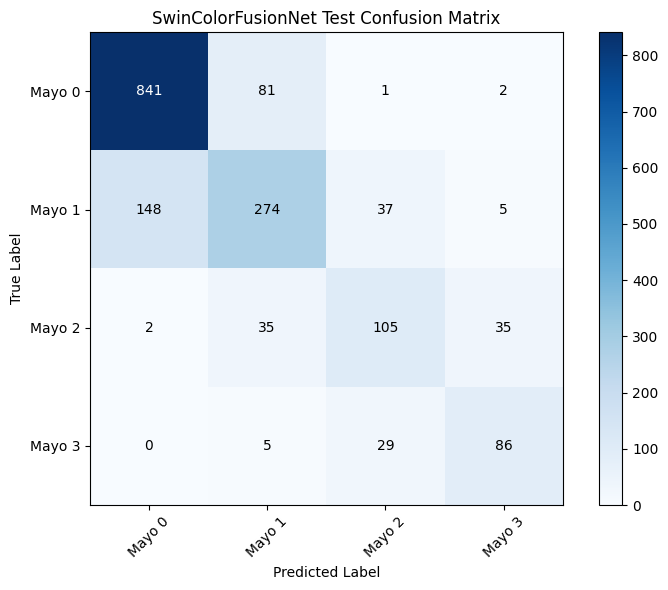

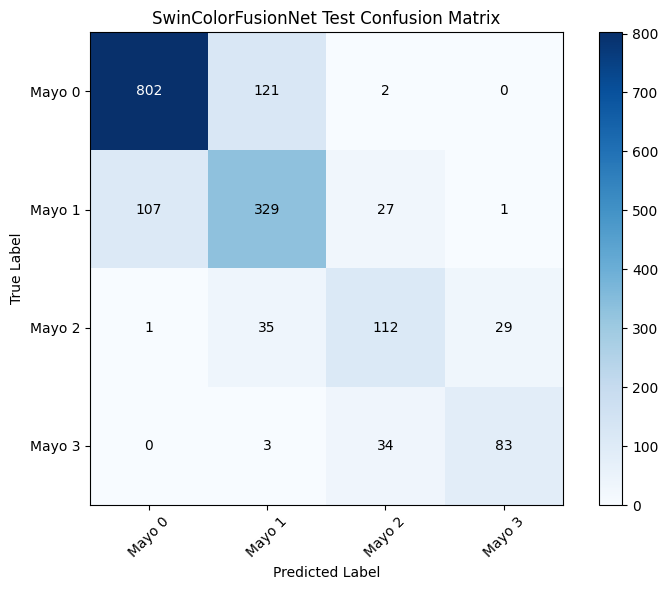

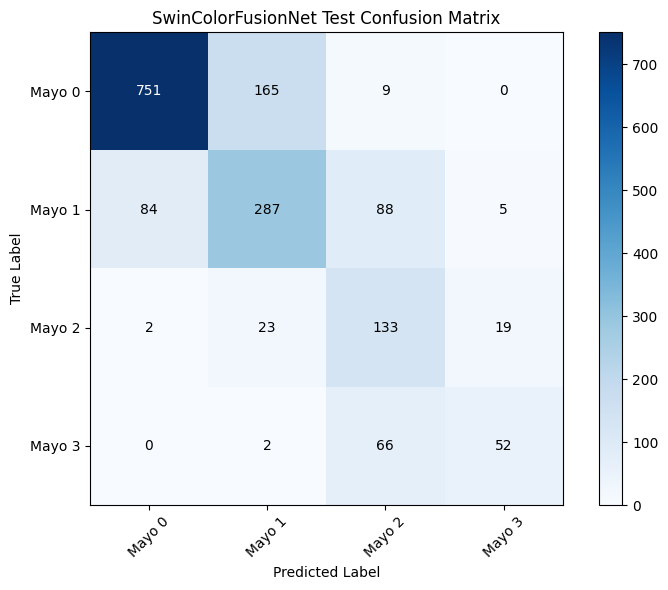

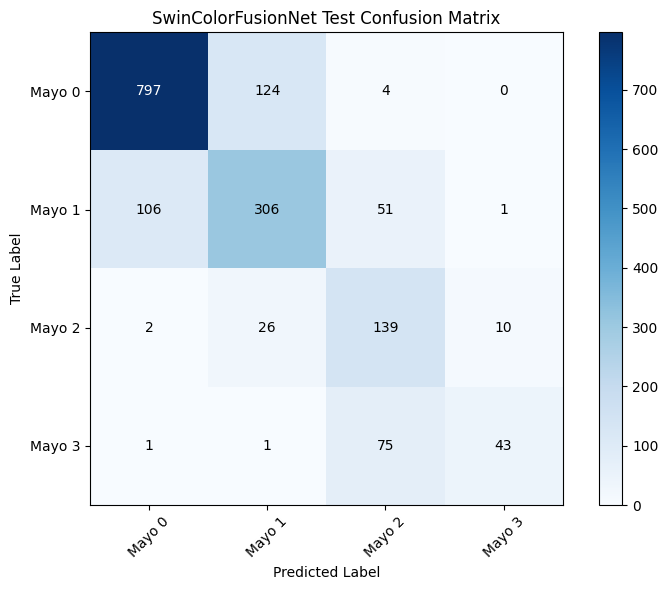

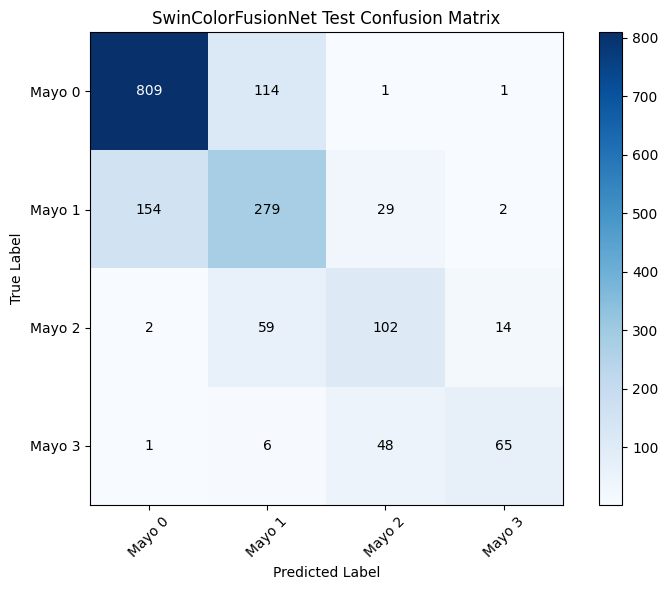

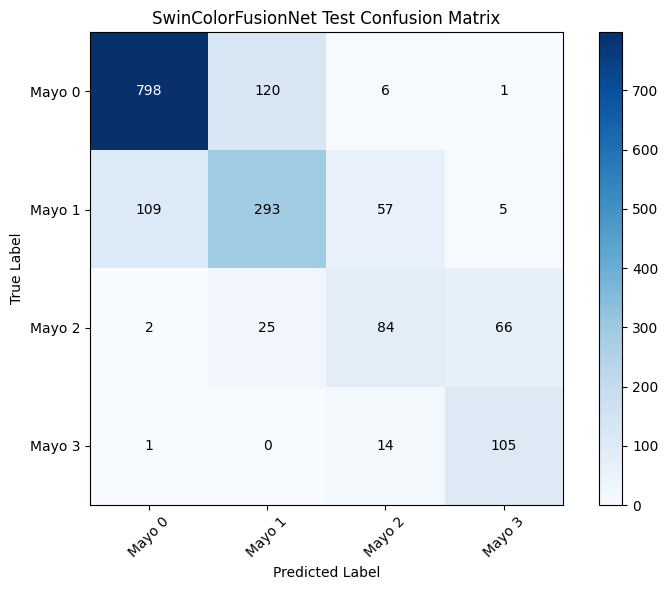

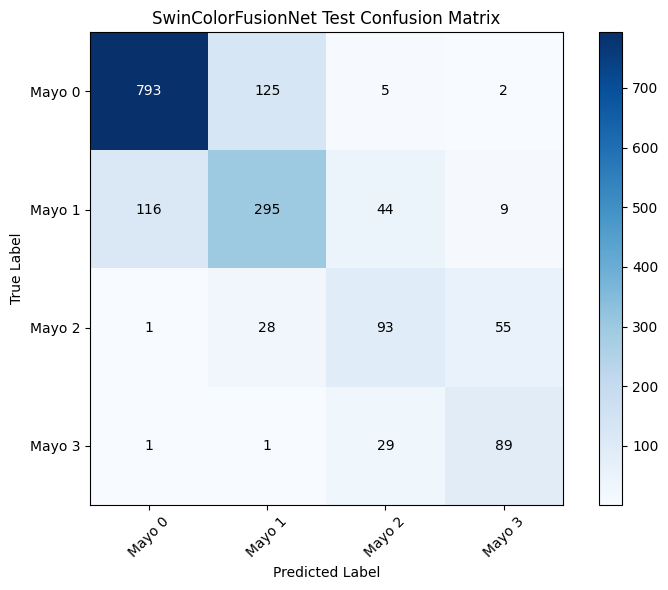

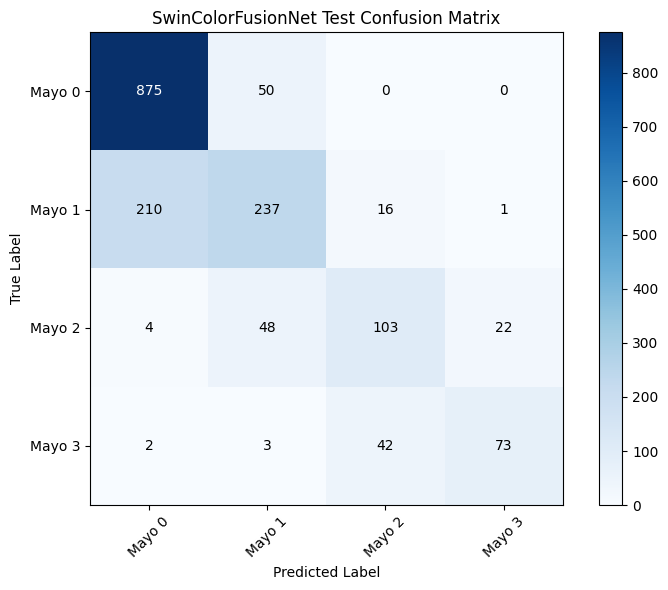

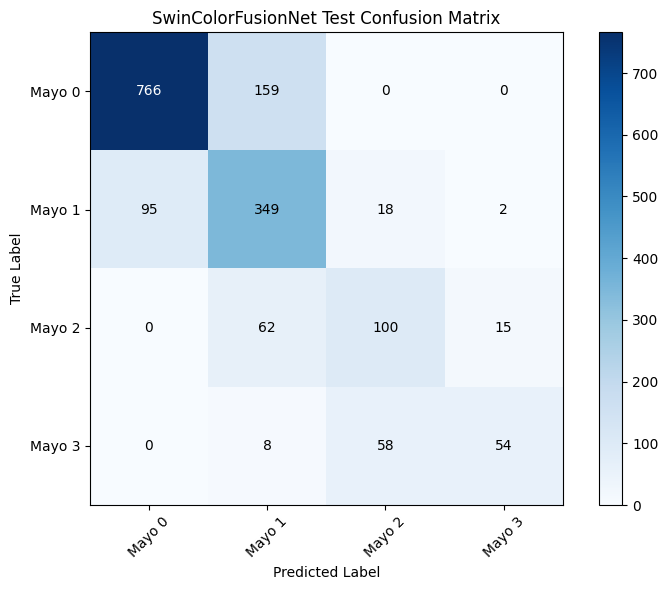

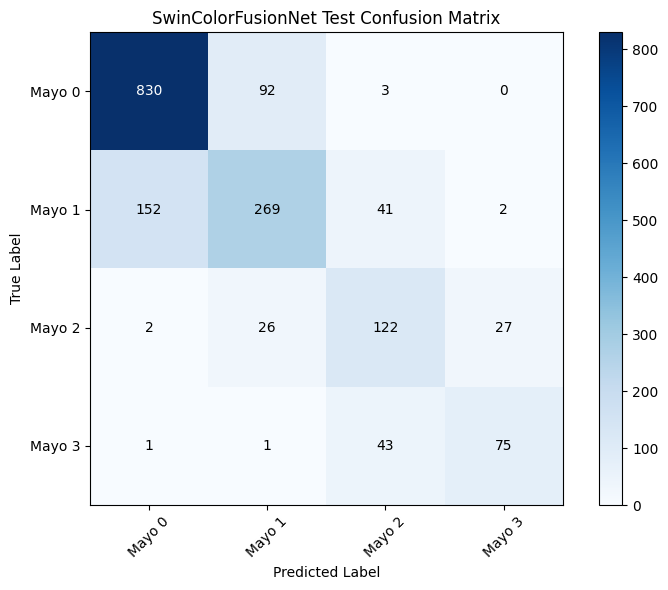

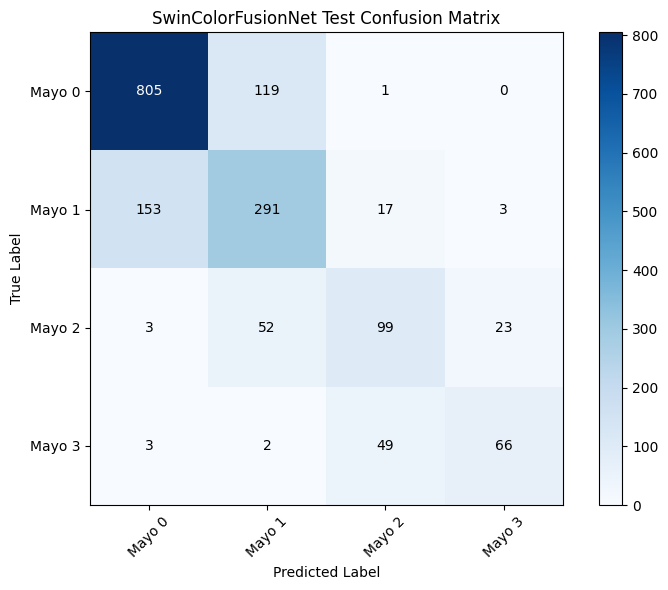

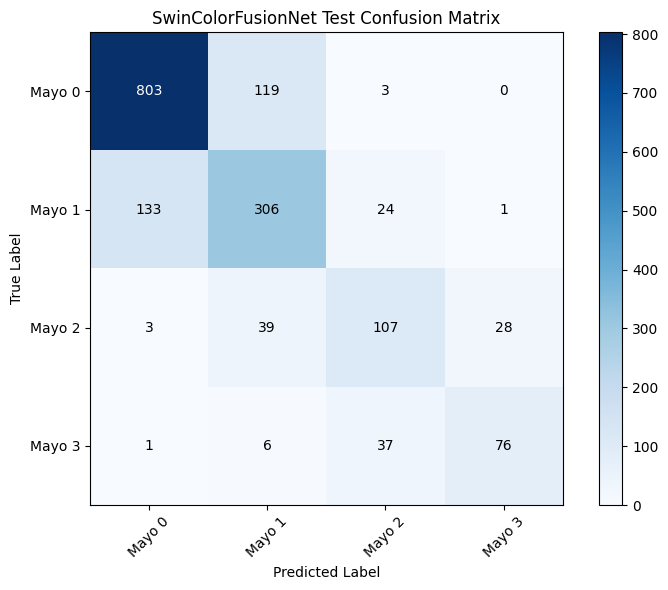

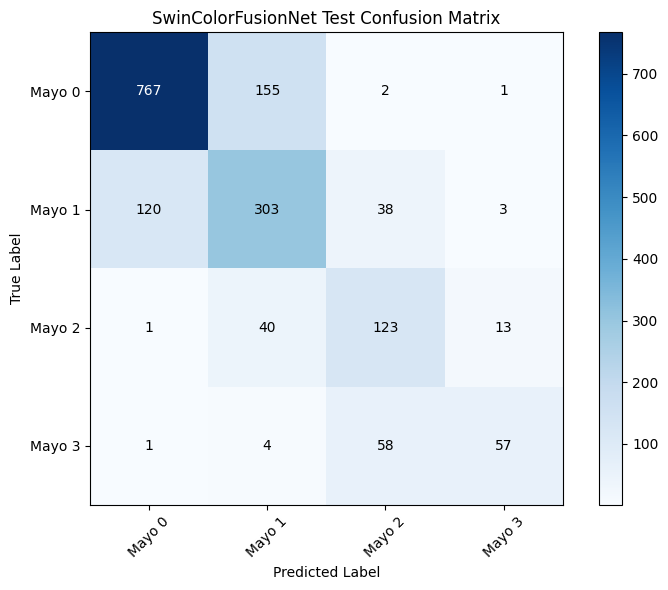

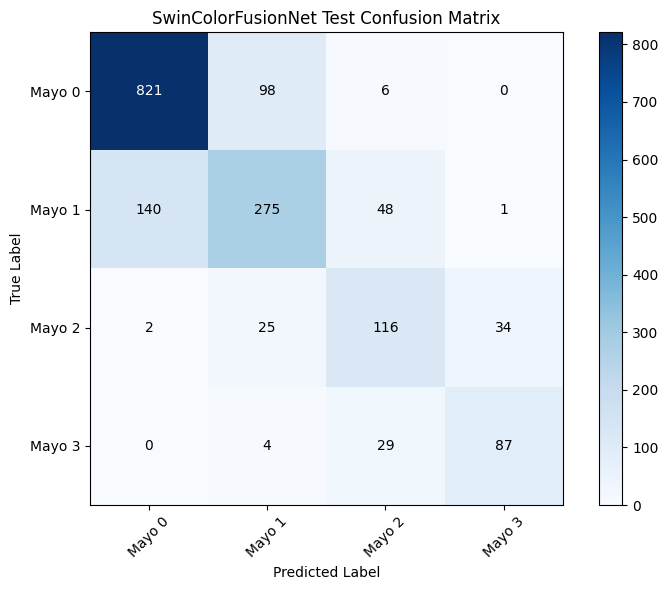

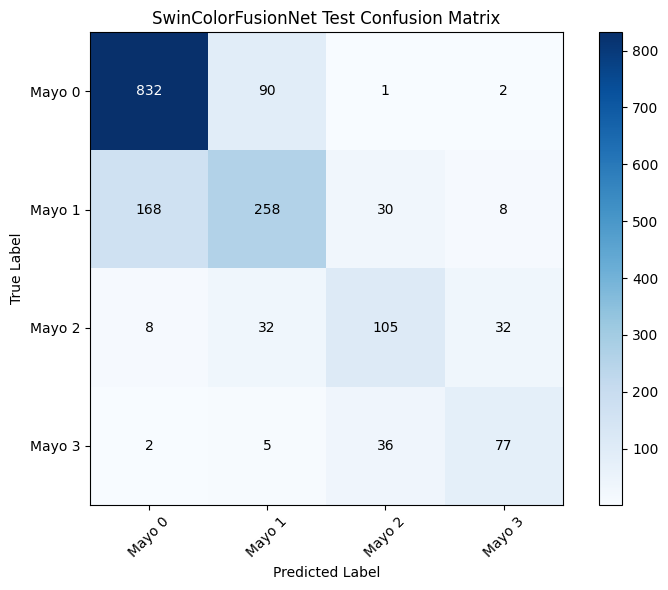

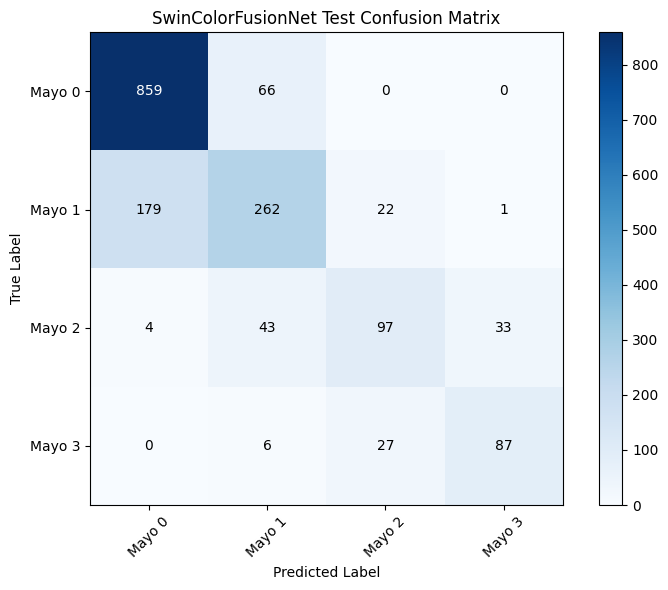

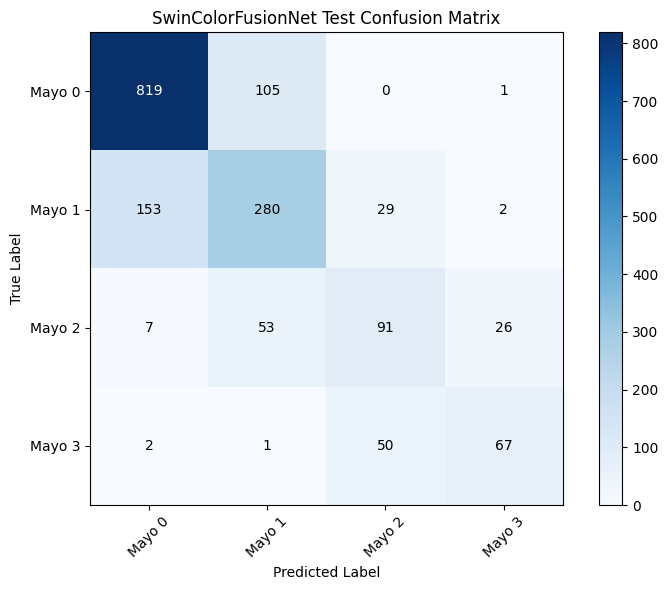

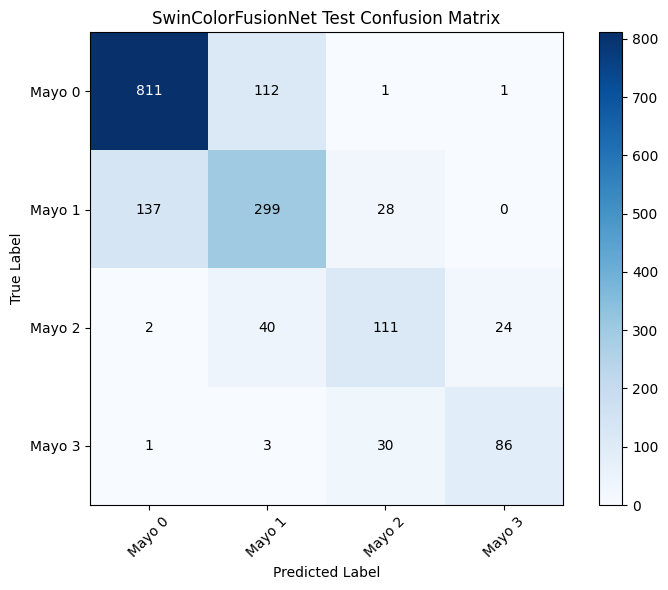

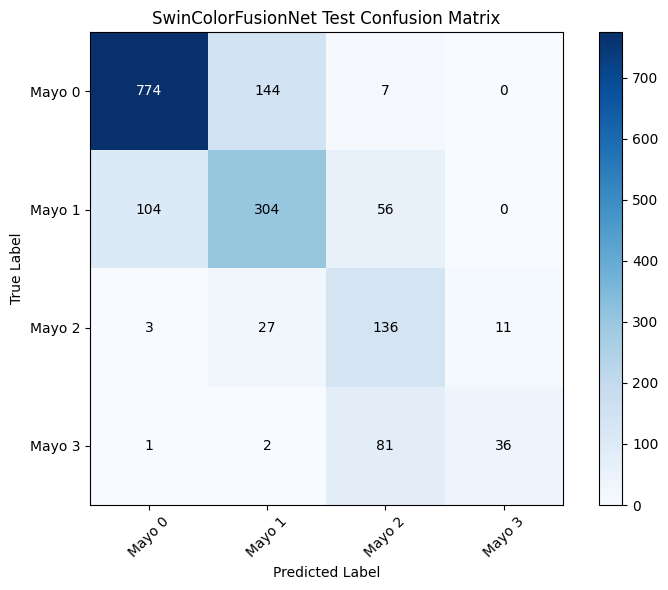

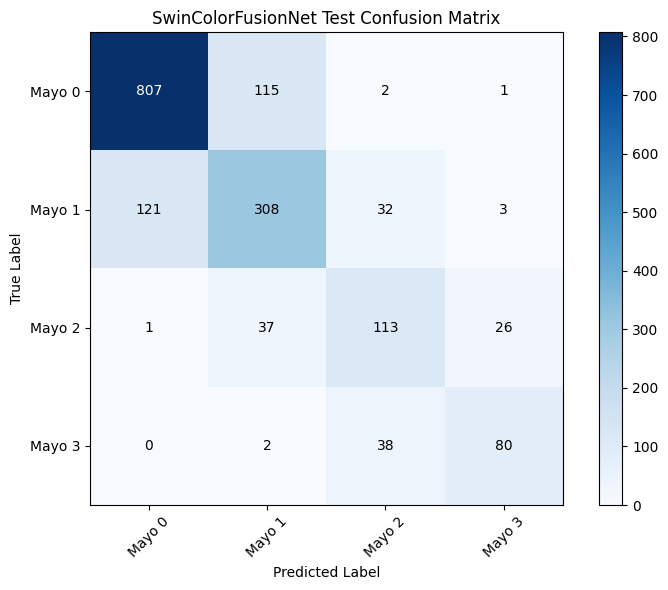

In [8]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_qwk',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [30, 60]
        },
        'lr': {
            'values': [0.0001, 0.00001]
        },
        'batch_size': {
            'values': [16, 32, 64, 128, 256]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DI725_Term_Project", entity="halil-donmezbilek")
wandb.agent(sweep_id, function=train_model, count=20)

# Statistical Model Performance Comparison

In [10]:
naive_predictions = baseline_model.predict(X_test)
true_labels = y_test
naive_qwk = cohen_kappa_score(true_labels, naive_predictions, weights='quadratic')
print("Naive Model QWK:", naive_qwk)

Naive Model QWK: 0.0


In [15]:
def dnn_evaluate_test_model(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  deep_nn_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
  print("Deep Neural Network QWK:", deep_nn_qwk)
  return all_preds, all_labels, deep_nn_qwk

dnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4144, 0.2877, 0.2182], std=[0.2867, 0.2085, 0.1626])
])

dnn_test_paths = gather_paths(test_data)
dnn_test_dataset = BMPDataset(root=data_dir / 'test_set', file_paths=dnn_test_paths, transform=dnn_transform)
dnn_test_dataloader = DataLoader(dnn_test_dataset, batch_size=32, shuffle=False)
dnn_model = non_transformer_initialize_model().to(device)

non_transformer_best_model_path = "/content/drive/MyDrive/DI725_Term_Project/non_transformer_best_model_path.pth"
dnn_model.load_state_dict(torch.load(non_transformer_best_model_path))

dnn_predictions, dnn_true_labels, dnn_qwk = dnn_evaluate_test_model(dnn_model, dnn_test_dataloader, device)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 193MB/s]


Deep Neural Network QWK: 0.760162218398893


In [19]:
def swin_evaluate_model(model, dataloader, device):
  model.eval()
  running_corrects = 0
  all_preds = []
  all_labels = []
  for data in dataloader:
    inputs, color_features, labels = data
    inputs, color_features, labels = inputs.to(device), color_features.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs, color_features)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

  swin_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
  print("SwinColorFusionNet QWK:", swin_qwk)
  return all_preds, all_labels, swin_qwk

swin_model = SwinColorFusionNet(num_classes=4, pretrained=True, num_bins=32).to(device)
swin_model.load_state_dict(torch.load("/content/drive/MyDrive/DI725_Term_Project/best_model_qgdryzn0.pth"))

swin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4144, 0.2877, 0.2182], std=[0.2867, 0.2085, 0.1626])
])


test_paths = []
test_labels = []
for class_name, paths in test_data.items():
    label = int(class_name.split(' ')[-1])
    test_paths.extend(paths)
    test_labels.extend([label] * len(paths))

swin_test_dataset = SwinDataset(test_paths, test_labels, transform=swin_transform, num_bins=32)
swin_test_loader = DataLoader(swin_test_dataset, batch_size=32, shuffle=False, num_workers=8)

swin_predictions, swin_true_labels, swin_qwk = swin_evaluate_model(swin_model, swin_test_loader, device)


SwinColorFusionNet QWK: 0.8556090783730261


In [27]:
wilcoxon_test_swin_naive = wilcoxon(swin_predictions, naive_predictions)
print("Wilcoxon test between SwinColorFusionNet and Naive model:", wilcoxon_test_swin_naive)
wilcoxon_test_swin_deep_nn = wilcoxon(swin_predictions, dnn_predictions)
print("Wilcoxon test between SwinColorFusionNet and Deep Neural Network model:", wilcoxon_test_swin_deep_nn)

Wilcoxon test between SwinColorFusionNet and Naive model: WilcoxonResult(statistic=0.0, pvalue=5.1416723192901964e-113)
Wilcoxon test between SwinColorFusionNet and Deep Neural Network model: WilcoxonResult(statistic=31535.0, pvalue=3.0724016064831597e-27)
